In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-model/best_mobilenetv2_CIPHAR10.pth
/kaggle/input/quantize-py/quantize.py


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import random



from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
import torchvision.models as models
import os
!pip install wandb -qqq
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# TASK1  - Run Ciphar 10 on mobilenetv2

1. DATA PREPARATION

In [3]:
# --------------------------------------------------------
# Mixup + CutMix utilities
# --------------------------------------------------------

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    batch_size, _, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cx = random.randint(0, W)
    cy = random.randint(0, H)
    w = int(W * (1 - lam)**0.5)
    h = int(H * (1 - lam)**0.5)

    x1 = max(cx - w // 2, 0)
    y1 = max(cy - h // 2, 0)
    x2 = min(cx + w // 2, W)
    y2 = min(cy + h // 2, H)

    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


In [4]:
# Task 1.1
#Data preparation

# --- (b) TRAINING STRATEGY HYPERPARAMETERS ---
BATCH_SIZE = 128
EPOCHS = 400
#LR_INITIAL = 0.1 
LR_INITIAL = 0.02
MOMENTUM = 0.9
#WEIGHT_DECAY = 5e-5
WEIGHT_DECAY = 3e-4
LR_MILESTONES = [80, 120,170,250,250,350]  # Epochs where LR is multiplied by 0.1 #at 80 accuracy jumped
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda:0


In [5]:
# --- (a) CIFAR-10 NORMALIZATION VALUES ---
# Mean and Std Dev calculated over the entire CIFAR-10 training set
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2023, 0.1994, 0.2010]

# --- TRAINING TRANSFORMS (with Augmentation) ---

import random
import numpy as np

# Define a fixed seed
FIXED_SEED = 42

def set_seed(seed):
    """Sets the seed for reproducibility across multiple libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        # Recommended for deterministic behavior, but may impact performance
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function early
set_seed(FIXED_SEED)

def worker_init_fn(worker_id):
    """
    Initializes the seed for each worker process to ensure reproducibility
    of transforms when num_workers > 0.
    """
    # Use the global seed plus the worker ID to create a unique seed for the worker
    worker_seed = FIXED_SEED + worker_id
    set_seed(worker_seed)
    # Note: Calling set_seed(worker_seed) inside this function will re-seed
    # random, numpy, and torch for that specific worker process.

num_workers = 2 # Or any number > 0


# train_transforms = transforms.Compose([
#     # RandomCrop with padding 4 (to maintain 32x32)
#     transforms.RandomCrop(32, padding=4),
#     # RandomHorizontalFlip (p=0.5)
#     transforms.RandomHorizontalFlip(),
#     # Optional: Small ColorJitter (as discussed in part a)
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     transforms.ToTensor(),
#     # Normalization
#     transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
# ])

# # --- TEST/VALIDATION TRANSFORMS (Normalization only) ---
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
# ])
# --------------------------------------------------------
# Data Augmentation
# --------------------------------------------------------
input_size = 96
#batch_size = 128

train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomCrop(input_size, padding=4),
    transforms.RandomHorizontalFlip(),
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])
# Load Datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
# # Create DataLoaders
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=num_workers,
#     # Inject the reproducibility function here:
#     worker_init_fn=worker_init_fn 
# )

# # Test/validation data usually doesn't need this, as `shuffle=False`
# # and the transforms are deterministic, but adding it doesn't hurt.
# test_loader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=num_workers,
#     worker_init_fn=worker_init_fn 
# )
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data loaders prepared. Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


Data loaders prepared. Training samples: 50000, Test samples: 10000


# Performing Training

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]


MobileNetV2 configured and ready for training.

--- Starting Training ---
Epoch 1/400 | Train Loss: 2.3278 Acc: 0.1242 | Test Loss: 2.3343 Acc: 0.1000
Epoch 2/400 | Train Loss: 2.2847 Acc: 0.1343 | Test Loss: 2.1053 Acc: 0.1910
Epoch 3/400 | Train Loss: 2.2225 Acc: 0.1962 | Test Loss: 1.9618 Acc: 0.2413
Epoch 4/400 | Train Loss: 2.1870 Acc: 0.2452 | Test Loss: 1.9263 Acc: 0.3072
Epoch 5/400 | Train Loss: 2.1553 Acc: 0.2836 | Test Loss: 1.8538 Acc: 0.3844
Epoch 6/400 | Train Loss: 2.1427 Acc: 0.2952 | Test Loss: 2.0730 Acc: 0.2961
Epoch 7/400 | Train Loss: 2.1154 Acc: 0.3368 | Test Loss: 1.7640 Acc: 0.4764
Epoch 8/400 | Train Loss: 2.1039 Acc: 0.3725 | Test Loss: 1.6915 Acc: 0.5150
Epoch 9/400 | Train Loss: 2.0695 Acc: 0.4087 | Test Loss: 1.6470 Acc: 0.5372
Epoch 10/400 | Train Loss: 2.0481 Acc: 0.4336 | Test Loss: 1.5642 Acc: 0.5664
Epoch 11/400 | Train Loss: 2.0696 Acc: 0.4510 | Test Loss: 1.5868 Acc: 0.5805
Epoch 12/400 | Train Loss: 2.0179 Acc: 0.4725 | Test Loss: 1.5240 Acc: 0.6174

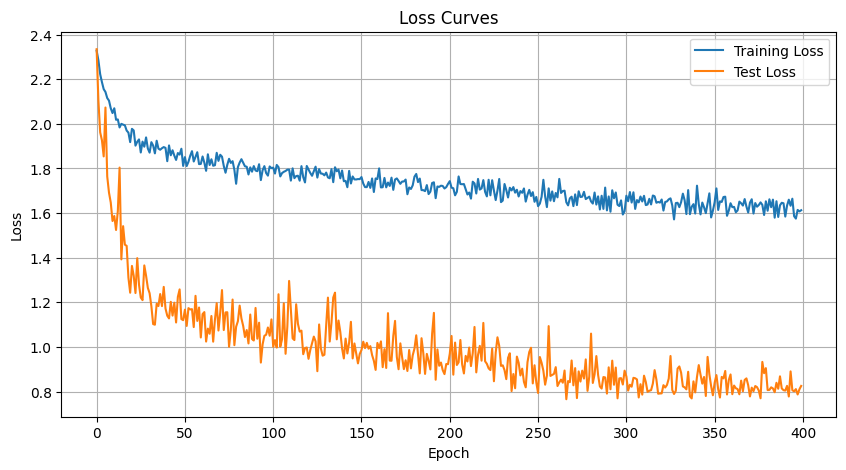

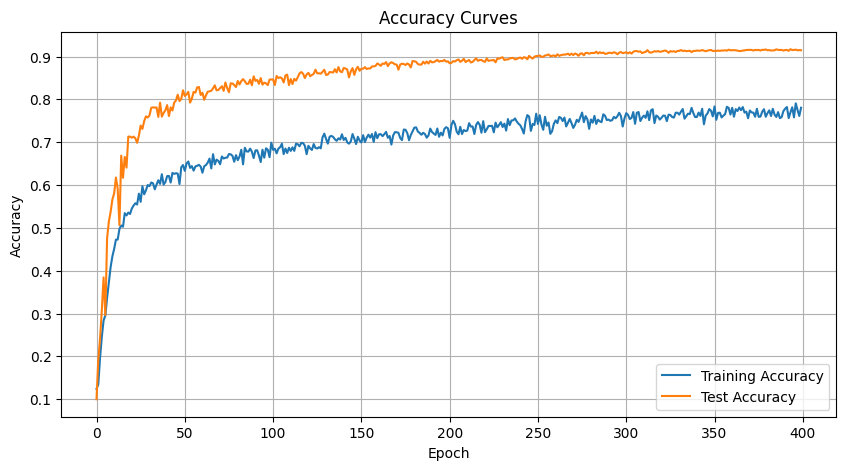

In [6]:
# --- (b) MOBILENETV2 CONFIGURATION ---

# 1. Initialize the MobileNetV2 model (width multiplier alpha=1.0 by default)
#model = mobilenet_v2(weights=None) # Start from scratch
model = mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
# 2. Modify the classifier for CIFAR-10 (10 classes)
# The classifier head is a sequential block: (Dropout -> Linear)
# The input feature size of the classifier is 1280 (standard MobileNetV2)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    # Dropout (with p=0.2 as specified)
    nn.Dropout(p=0.2), 
    # Final Linear layer for 10 classes
    nn.Linear(num_ftrs, 10) 
)

# Move model to device
model.to(DEVICE)

# --- TRAINING STRATEGY SETUP ---
#criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR_INITIAL, weight_decay=WEIGHT_DECAY)
# optimizer = optim.SGD(model.parameters(), 
#                       lr=LR_INITIAL, 
#                       momentum=MOMENTUM, 
#                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# scheduler = MultiStepLR(optimizer, 
#                         milestones=LR_MILESTONES, 
#                         gamma=0.1) # Gamma is the factor by which to reduce LR

print("MobileNetV2 configured and ready for training.")



#2. Model Preparation


# def train_epoch(model, loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
    
#     for inputs, labels in loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
        
#         # Calculate accuracy
#         _, predicted = torch.max(outputs.data, 1)
#         correct_predictions += (predicted == labels).sum().item()

#     epoch_loss = running_loss / len(loader.dataset)
#     epoch_acc = correct_predictions / len(loader.dataset)
#     return epoch_loss, epoch_acc

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

         # ----- Randomly choose Mixup or CutMix -----
        r = random.random()
        if r < 0.5:
            # Mixup
            x, y_a, y_b, lam = mixup_data(inputs, labels, alpha=0.2)
        else:
            # CutMix
            x, y_a, y_b, lam = cutmix_data(inputs, labels, alpha=1.0)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        #loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct_predictions / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()

    test_loss = running_loss / len(loader.dataset)
    test_acc = correct_predictions / len(loader.dataset)
    return test_loss, test_acc


#3 Training ,Main Training Loop

# --- MAIN TRAINING LOOP ---
print("\n--- Starting Training ---")

# Lists to store results for curve plotting (part c)
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    # 1. Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # 2. Adjust Learning Rate
    scheduler.step()
    
    # 3. Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    
    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print progress
    print(f'Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    # Save the best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_mobilenetv2_CIPHAR10.pth')

print("--- Training Finished ---")
print(f"Best Test Top-1 Accuracy: {best_acc:.4f}")



import matplotlib.pyplot as plt

def plot_curves(train_data, test_data, title, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(train_data, label=f'Training {ylabel}')
    plt.plot(test_data, label=f'Test {ylabel}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# After training completes, call the plotting functions:
plot_curves(train_losses, test_losses, 'Loss Curves', 'Loss')
plot_curves(train_accuracies, test_accuracies, 'Accuracy Curves', 'Accuracy')


# Perform Inference

In [7]:
#Inference on test_batch
TEST_BATCH_FILE = '/kaggle/input/ciphar-best-model/keras/default/1/data/cifar-10-batches-py/test_batch'

MODEL_SAVE_PATH = '/kaggle/input/best-model/best_mobilenetv2_CIPHAR10.pth'
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2023, 0.1994, 0.2010]
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
#DROPOUT_RATE = 0.2
DROPOUT_RATE = 0

input_size = 96
# --- DATA PREPARATION (TEST ONLY) ---
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
# ])
test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Inference will run on {len(test_dataset)} test samples.")

# --- 1. RECREATE MODEL ARCHITECTURE ---
def load_best_model(path, device):
    # Initialize the base MobileNetV2 architecture
    model = mobilenet_v2(weights=None) 

    # Reconfigure the classifier head (matching the trained architecture)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE), 
        nn.Linear(num_ftrs, 10) 
    )

    # Load the saved state dictionary (weights)
    try:
        # Map location ensures compatibility if saved on GPU but loaded on CPU (or vice-versa)
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"Successfully loaded model weights from: {path}")
    except FileNotFoundError:
        print(f"Error: Model file not found at {path}. Ensure training was run and the file exists.")
        return None
    
    # Move model to the target device
    model.to(device)
    
    # --- 2. SET MODEL TO EVALUATION MODE ---
    # This disables Dropout and sets Batch Normalization layers to use 
    # the learned mean and variance, ensuring deterministic results.
    model.eval()
    
    return model

model = load_best_model(MODEL_SAVE_PATH, DEVICE)


if model is None:
    exit()

# --- 3. RUN INFERENCE ON TEST DATA ---
def perform_inference(model, test_loader, device):
    total_correct = 0
    total_samples = 0
    
    # Disable gradient calculations during inference to save memory and speed up computation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Get the predicted class (index of the max log-probability)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    final_accuracy = 100 * total_correct / total_samples
    
    print(f"\n--- INFERENCE RESULTS ---")
    print(f"Total Test Samples: {total_samples}")
    print(f"Total Correct Predictions: {total_correct}")
    print(f"Final Test Top-1 Accuracy: {final_accuracy:.2f}%")

# Execute the inference
perform_inference(model, test_loader, DEVICE)

Inference will run on 10000 test samples.
Successfully loaded model weights from: /kaggle/input/best-model/best_mobilenetv2_CIPHAR10.pth

--- INFERENCE RESULTS ---
Total Test Samples: 10000
Total Correct Predictions: 9170
Final Test Top-1 Accuracy: 91.70%


# Pruning

In [8]:
def prune_model_by_magnitude(model, pruning_ratio, apply_to_quant_layers=True):
    """
    Prunes weights with the smallest magnitude across the entire model.

    Args:
        model (nn.Module): The PyTorch model to prune.
        pruning_ratio (float): The percentage of weights to set to zero (e.g., 0.5 for 50%).
        apply_to_quant_layers (bool): If True, applies pruning to QuantConv2d/QuantLinear.
    """
    if not (0.0 < pruning_ratio < 1.0):
        print("Warning: Pruning ratio must be between 0 and 1. Skipping pruning.")
        return

    # 1. Collect all weight magnitudes
    all_weights = []
    # Identify the types of modules to prune based on the flag
    prunable_types = (torch.nn.Conv2d, torch.nn.Linear)
    if apply_to_quant_layers:
        prunable_types = prunable_types + (QuantConv2d, QuantLinear)

    for name, module in model.named_modules():
        if isinstance(module, prunable_types):
            # Use the absolute value of the weight tensor (flattened)
            all_weights.append(module.weight.data.abs().flatten())
    
    # Check if any weights were found
    if not all_weights:
        print("No prunable layers found.")
        return

    # Concatenate all magnitudes into a single tensor
    weights_tensor = torch.cat(all_weights)

    # 2. Determine the Threshold
    # Calculate the index corresponding to the lowest 'pruning_ratio' percentile
    k = int(pruning_ratio * weights_tensor.numel())
    
    # Find the magnitude threshold at that percentile
    # torch.kthvalue finds the k-th smallest element
    threshold, _ = torch.kthvalue(weights_tensor, k=k)
    
    # 3. Apply the Pruning Mask
    print(f"\nApplying Pruning Mask: Ratio={pruning_ratio:.2f}, Threshold={threshold.item():.6f}")

    total_pruned = 0
    total_weights = 0

    for name, module in model.named_modules():
        if isinstance(module, prunable_types):
            weight = module.weight.data
            
            # Create a mask: True where magnitude >= threshold, False otherwise
            mask = weight.abs().ge(threshold).float()
            
            # Apply the mask permanently to the weight tensor
            weight.mul_(mask)
            
            # Update statistics
            pruned_count = (mask == 0).sum().item()
            total_pruned += pruned_count
            total_weights += weight.numel()

    final_ratio = total_pruned / total_weights if total_weights > 0 else 0
    print(f"Pruning complete. Total weights pruned: {total_pruned}/{total_weights} ({final_ratio:.2%})")

# QUANTIZE.py

In [9]:
# quant_nbit.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# ---------- core helpers (uniform quant) ----------
def qparams_from_minmax(xmin, xmax, n_bits=8, unsigned=False, asymetric = False,eps=1e-12):
    """
    Returns (scale, zero_point, qmin, qmax) for uniform quant.
    - unsigned=True  -> [0, 2^b - 1]
    - unsigned=False -> symmetric int range [-2^(b-1)+1, 2^(b-1)-1]
    """
    if unsigned:
        qmin, qmax = 0, (1 << n_bits) - 1
        # (common for post-ReLU) ensure non-negative min for tighter range
        xmin = torch.zeros_like(xmin)
        scale = (xmax - xmin).clamp_min(eps) / float(qmax - qmin)
        zp = torch.round(-xmin / scale).clamp(qmin, qmax)
    elif not asymetric:
        qmax = (1 << (n_bits - 1)) - 1
        qmin = -qmax
        max_abs = torch.max(xmin.abs(), xmax.abs()).clamp_min(eps)
        scale = max_abs / float(qmax)
        zp = torch.zeros_like(scale)
    else :
        qmax = (1 << (n_bits - 1)) - 1
        qmin = -qmax - 1
        # 1. Calculate Scale:
        scale = (xmax - xmin).clamp_min(eps) / float(qmax - qmin)
        
        # 2. Calculate Zero Point (ZP):
        # zp = qmin - xmin / scale  OR  zp = -xmin / scale
        zp = torch.round(qmin - xmin / scale).clamp(qmin, qmax)
    return scale, zp, int(qmin), int(qmax)

def quantize(x, scale, zp, qmin, qmax):
    q = torch.round(x / scale + zp)
    return q.clamp(qmin, qmax)

def dequantize(q, scale, zp):
    return (q - zp) * scale

# ---------- activation fake-quant (with calibration then freeze) ----------
class ActFakeQuant(nn.Module):
    """
    Per-tensor activation fake-quant with configurable bits.
    Intended to be placed AFTER ReLU -> use unsigned=True.
    """
    def __init__(self, n_bits=8, unsigned=True):
        super().__init__()
        self.n_bits = n_bits
        self.unsigned = unsigned
        self.register_buffer("min_val", torch.tensor(float("inf")))
        self.register_buffer("max_val", torch.tensor(float("-inf")))
        self.register_buffer("scale", torch.tensor(1.0))
        self.register_buffer("zp", torch.tensor(0.0))
        self.frozen = False
        self.qmin, self.qmax = None, None

    @torch.no_grad()
    def observe(self, x):
        self.min_val = torch.minimum(self.min_val, x.min())
        self.max_val = torch.maximum(self.max_val, x.max())

    @torch.no_grad()
    def freeze(self):
        scale, zp, qmin, qmax = qparams_from_minmax(
            self.min_val, self.max_val, n_bits=self.n_bits, unsigned=self.unsigned,asymetric=True
        )
        self.scale.copy_(scale)
        self.zp.copy_(zp)
        self.qmin, self.qmax = qmin, qmax
        self.frozen = True

    def forward(self, x):
        if not self.frozen:
            self.observe(x)
            return x
        q = quantize(x, self.scale, self.zp, self.qmin, self.qmax)
        return dequantize(q, self.scale, self.zp)

# ---------- weight fake-quant wrappers (freeze-from-weights) ----------
class QuantConv2d(nn.Conv2d):
    """
    Per-tensor symmetric int quantization for weights with configurable bits.
    We compute/freeze params once from trained weights (PTQ).
    """
    def __init__(self, *args, weight_bits=8, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight_bits = weight_bits
        self.register_buffer("w_scale", torch.tensor(1.0))
        self.register_buffer("w_zp", torch.tensor(0.0))
        self.frozen = False
        self.qmin = None
        self.qmax = None

    @torch.no_grad()
    def freeze(self):
        w = self.weight.detach().cpu()
        w_min, w_max = w.min(), w.max()
        scale, zp, qmin, qmax = qparams_from_minmax(
            w_min, w_max, n_bits=self.weight_bits, unsigned=False,asymetric=True
        )
        self.w_scale.copy_(scale)
        self.w_zp.copy_(zp)
        self.qmin, self.qmax = qmin, qmax
        self.frozen = True

    def forward(self, x):
        if not self.frozen:
            return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        q = quantize(self.weight, self.w_scale, self.w_zp, self.qmin, self.qmax)
        w_dq = dequantize(q, self.w_scale, self.w_zp)
        return F.conv2d(x, w_dq, self.bias, self.stride, self.padding, self.dilation, self.groups)

class QuantLinear(nn.Linear):
    def __init__(self, *args, weight_bits=8, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight_bits = weight_bits
        self.register_buffer("w_scale", torch.tensor(1.0))
        self.register_buffer("w_zp", torch.tensor(0.0))
        self.frozen = False
        self.qmin = None
        self.qmax = None

    @torch.no_grad()
    def freeze(self):
        w = self.weight.detach().cpu()
        w_min, w_max = w.min(), w.max()
        scale, zp, qmin, qmax = qparams_from_minmax(
            w_min, w_max, n_bits=self.weight_bits, unsigned=False,asymetric=True
        )
        self.w_scale.copy_(scale)
        self.w_zp.copy_(zp)
        self.qmin, self.qmax = qmin, qmax
        self.frozen = True

    def forward(self, x):
        if not self.frozen:
            return F.linear(x, self.weight, self.bias)
        q = quantize(self.weight, self.w_scale, self.w_zp, self.qmin, self.qmax)
        w_dq = dequantize(q, self.w_scale, self.w_zp)
        return F.linear(x, w_dq, self.bias)

# ---------- model surgery with user-selected bits ----------
def swap_to_quant_modules(model, weight_bits=8, act_bits=8, activations_unsigned=True):
    """
    - Replace every Conv2d/Linear with Quant* using weight_bits.
    - Replace every ReLU with Sequential(ReLU, ActFakeQuant(act_bits)).
    """
    for name, m in list(model.named_children()):
        swap_to_quant_modules(m, weight_bits, act_bits, activations_unsigned)

        if isinstance(m, nn.Conv2d):
            q = QuantConv2d(
                m.in_channels, m.out_channels, m.kernel_size,
                stride=m.stride, padding=m.padding, dilation=m.dilation,
                groups=m.groups, bias=(m.bias is not None),
                weight_bits=weight_bits
            )
            q.weight.data.copy_(m.weight.data)
            if m.bias is not None:
                q.bias.data.copy_(m.bias.data)
            setattr(model, name, q)

        elif isinstance(m, nn.Linear):
            q = QuantLinear(m.in_features, m.out_features, bias=(m.bias is not None), weight_bits=weight_bits)
            q.weight.data.copy_(m.weight.data)
            if m.bias is not None:
                q.bias.data.copy_(m.bias.data)
            setattr(model, name, q)

        elif isinstance(m, nn.ReLU):
            seq = nn.Sequential(OrderedDict([
                ("relu", nn.ReLU(inplace=getattr(m, "inplace", False))),
                ("aq", ActFakeQuant(n_bits=act_bits, unsigned=activations_unsigned)),
            ]))
            setattr(model, name, seq)

def freeze_all_quant(model):
    """
    Freeze weights and activations (finalize scales/ZPs) after calibration.
    """
    for mod in model.modules():
        if isinstance(mod, (QuantConv2d, QuantLinear)):
            mod.freeze()
        if isinstance(mod, nn.Sequential):
            for sub in mod.modules():
                if isinstance(sub, ActFakeQuant):
                    sub.freeze()

def model_size_bytes_fp32(model):
    """Total size of all parameters if stored as FP32 (4 bytes each)."""
    total = 0
    for name,p in model.named_parameters():
        # Check if the parameter is a weight tensor
        # if "weight" in name:
            
        #     # Count only non-zero elements (the sparse structure)
        #     non_zero_elements = torch.count_nonzero(p.data).item()
            
        #     # Add size: (Non-zero elements) * (Byte size of N-bit weight)
        #     total += non_zero_elements * 4
            
        # elif "bias" in name:
        #     # Biases are typically kept as FP32 (4 bytes)
        #     total += p.numel() * 4
       
        total += p.numel() * 4
    return total

def model_size_bytes_quant(model, weight_bits=8):
    """Total size if all weights were stored as intN, biases stay FP32."""
    total = 0
    for name, p in model.named_parameters():
        if "weight" in name:
            total += torch.count_nonzero(p.data).item() * weight_bits // 8  # intN
        elif "bias" in name:
            total += p.numel() * 4                 # keep biases FP32
    return total

def print_compression(model, weight_bits=8):
    fp32_size = model_size_bytes_fp32(model)
    quant_size = model_size_bytes_quant(model, weight_bits)
    ratio = fp32_size / max(quant_size, 1)
    print("=== Compression Summary ===")
    print(f"FP32 model size:             {fp32_size/1024/1024:.2f} MB")
    print(f"Quantized size + pruning:    {quant_size/1024/1024:.2f} MB (weights={weight_bits}-bit)")
    print(f"Compression ratio: {ratio:.2f}x")
    print("===========================")


In [10]:
def evaluate(model, testloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate((testloader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.cpu().max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().item())
        final_acc = 100 * correct / total
    return final_acc

# Model Compression

In [11]:
weight_quantize_bits = 8 #args.weight_quant_bits
act_quantize_bits = 8 #args.activation_quant_bits

model = load_best_model(MODEL_SAVE_PATH, DEVICE)


#perform pruning
PRUNING_LEVEL = 0.6
prune_model_by_magnitude(model, PRUNING_LEVEL, apply_to_quant_layers=False)
# performing Quantization
swap_to_quant_modules(model, weight_bits=weight_quantize_bits, act_bits=act_quantize_bits, activations_unsigned=True)
model.to(DEVICE)
with torch.no_grad():
    for i,(x,_) in enumerate(train_loader):#should be train_loader
        x = x.to(DEVICE)
        y = model(x)
        if i>=100: # calibration with 5 batches
            break

freeze_all_quant(model)
quantize_test_acc = evaluate(model, test_loader, DEVICE)
print(f"Quantized Test Acc={quantize_test_acc:.2f}%")
print_compression(model,weight_bits=weight_quantize_bits)

Successfully loaded model weights from: /kaggle/input/best-model/best_mobilenetv2_CIPHAR10.pth

Applying Pruning Mask: Ratio=0.60, Threshold=0.304221
Pruning complete. Total weights pruned: 1321535/2202560 (60.00%)
Quantized Test Acc=90.97%
=== Compression Summary ===
FP32 model size:             8.53 MB
Quantized size + pruning:    0.92 MB (weights=8-bit)
Compression ratio: 9.26x


# Weights & Biases

In [12]:
# import wandb
# wandb.login(key ='bf77f5f1c4119e980c1e7dd625ad82a4624f2d94')
# import itertools

# # Define the sweep configuration
# sweep_config = {
#     'method': 'grid',  # Use 'grid' for trying all combinations
#     'parameters': {
#         'weight_quantize_bits': {
#             'values': [2,4,8]
#         },
#         'act_quantize_bits': {
#             'values': [2,4,8]
#         },
#         'pruning_level': {
#             'values': [0.5, 0.6,0.8]
#         }
#     }
# }

# metric = {
#     'name': 'quantized_acuracy',
#     'goal': 'maximize'   
#     }
# sweep_config['metric'] = metric

# # Define the training function that W&B will run for each configuration
# def train():
#     # Initialize a new W&B run
#     wandb.init()

#     # Access hyperparameters from wandb.config
#     config = wandb.config

#     # Set device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model = load_best_model(MODEL_SAVE_PATH, device)


#     #perform pruning
#     PRUNING_LEVEL = config.pruning_level
#     prune_model_by_magnitude(model, PRUNING_LEVEL, apply_to_quant_layers=False)
#     # performing Quantization
#     swap_to_quant_modules(model, weight_bits=config.weight_quantize_bits, act_bits=config.act_quantize_bits, activations_unsigned=True)
#     model.to(DEVICE)
#     with torch.no_grad():
#         for i,(x,_) in enumerate(train_loader):#should be train_loader
#             x = x.to(DEVICE)
#             y = model(x)
#             if i>=100: # calibration with 5 batches
#                 break

#     freeze_all_quant(model)
#     quantize_test_acc = evaluate(model, test_loader, device)

#     fp32_size = model_size_bytes_fp32(model)
#     weight_bits = config.weight_quantize_bits
#     quant_size = model_size_bytes_quant(model, weight_bits)
#     ratio = fp32_size / max(quant_size, 1)
#     print("=== Compression Summary ===")
#     print(f"FP32 model size:             {fp32_size/1024/1024:.2f} MB")
#     print(f"Quantized size + pruning:    {quant_size/1024/1024:.2f} MB (weights={weight_bits}-bit)")
#     print(f"Compression ratio: {ratio:.2f}x")
#     print("===========================")

    
#     wandb.log({"quantized_test_accuracy": quantize_test_acc})
#     wandb.log({"compression_ratio": ratio})
    
#     print(f"Quantized Test Acc={quantize_test_acc:.2f}%")


# # Create the sweep ID
# sweep_id = wandb.sweep(sweep_config, project="quant_model_ciphar10")

# # Run the sweep
# # This will run the 'train' function for each configuration in the sweep_config
# wandb.agent(sweep_id, train)

# print("W&B sweep complete. Go to your W&B project page to view the sweep results and parallel coordinate plot.")
    